# Pre-Analysis

## 1. Imports

In [1]:
import os
import time 
import requests
import webbrowser
import pandas as pd
from dotenv import load_dotenv

load_dotenv()

True

## 2. Configuration

In [2]:
CLIENT_ID = os.getenv("CLIENT_ID")                              # Replace with your Strava Client ID
CLIENT_SECRET = os.getenv("CLIENT_SECRET")                      # Replace with your Strava Client Secret
REDIRECT_URI = os.getenv("REDIRECT_URI", "http://localhost")    # Must match what's set in your Strava API app

## 3. Step 1: Getting Authorization Code

In [3]:
auth_url = (
    f'https://www.strava.com/oauth/authorize?client_id={CLIENT_ID}'
    f'&response_type=code&redirect_uri={REDIRECT_URI}'
    f'&approval_prompt=force&scope=read,activity:read_all'
)

print("Opening browser for Strava authentication...")
webbrowser.open(auth_url)

# User will be redirected to http://localhost/?code=XXXX
# Copy the code from the URL and paste below
auth_code = input("Paste the authorization code here: ").strip()

Opening browser for Strava authentication...


## 4. Step 2: Exchange Code for Access Token

In [4]:
token_response = requests.post(
    'https://www.strava.com/oauth/token',
    data={
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET,
        'code': auth_code,
        'grant_type': 'authorization_code'
    }
)

if token_response.status_code != 200:
    print("Failed to get access token")
    print(token_response.text)
    exit()

token_data = token_response.json()
access_token = token_data['access_token']
refresh_token = token_data['refresh_token']
print("Access token obtained.")

Access token obtained.


## 5. Step 3: Fetch Activities

In [5]:
headers = {'Authorization': f'Bearer {access_token}'}
activities = []
page = 1

print("Downloading activities...")

while True:
    response = requests.get(
        f'https://www.strava.com/api/v3/athlete/activities?page={page}&per_page=200',
        headers=headers
    )
    data = response.json()
    if not data or 'errors' in data:
        break
    activities.extend(data)
    print(f"Fetched page {page}, {len(data)} activities")
    page += 1
    time.sleep(1)

Fetched page 1, 200 activities


## 6. Step 4: Save to CSV

In [6]:
if activities:
    df = pd.json_normalize(activities)
    df.to_csv('strava_activities.csv', index=False)
    print(f"Saved {len(df)} activities to strava_activities.csv")
else:
    print("No activities found or API call failed.")

Saved 200 activities to strava_activities.csv


# Strava Analysis

## 1. Imports and Data Load

In [7]:
import os
import time
import folium
import asyncio
import polyline
import nest_asyncio
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster
from shapely.geometry import LineString
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from pathlib import Path
from pyppeteer import launch

nest_asyncio.apply()

# Load your exported Strava CSV
df = pd.read_csv("strava_activities.csv")

## 2. Decode Polylines to Lat/Lng 

In [8]:
def decode_polylines(df):
    lines = []
    for p in df["map.summary_polyline"].dropna():
        try:
            coords = polyline.decode(p)
            if coords:
                lines.append(LineString(coords))
        except:
            continue
    return gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326")

gdf = decode_polylines(df)

## 3. Setup Output Directory

In [9]:
plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)

## 4. Load and Clean Strava Data

In [10]:
df = pd.read_csv("strava_activities.csv")

# Filter out entries without coordinates
df = df[df['start_latlng'].notna()]

# Safely parse 'start_latlng' strings to Python lists
df['start_latlng'] = df['start_latlng'].apply(
    lambda x: eval(x) if isinstance(x, str) and x.startswith("[") else None
)

df = df[df['start_latlng'].notna()]

# Split latitude and longitude into separate columns
df[['lat', 'lng']] = pd.DataFrame(df['start_latlng'].tolist(), index=df.index)

## 5. KMeans Clustering to Group Regions

In [11]:
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(df[["lat", "lng"]])

label_map = {
    0: "USA",   
    1: "Poland",
}

df["area"] = df["cluster"].map(label_map)

## 6. Static Region Plots

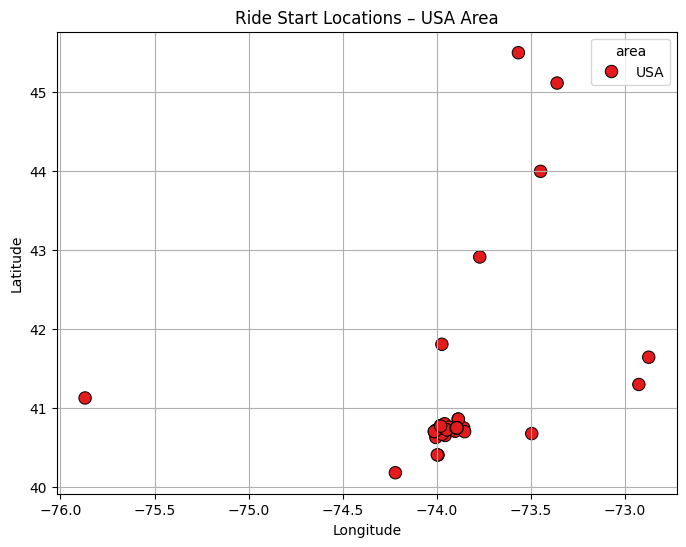

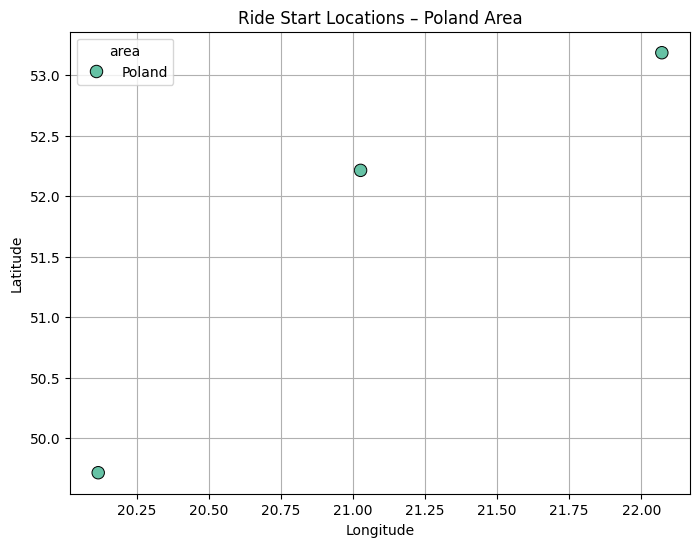

In [12]:
def save_region_plot(data, region_label, palette, filename):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=data,
        x="lng", y="lat",
        hue="area", palette=palette,
        s=80, edgecolor='black'
    )
    plt.title(f"Ride Start Locations – {region_label}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.savefig(plots_dir / filename)
    plt.show()

save_region_plot(df[df["lng"] < -50], "USA Area", "Set1", "usa_activities.png")
save_region_plot(df[df["lng"] > 0], "Poland Area", "Set2", "poland_activities.png")

## 7. Interactive Folium Map with Routes

### 7.1 Helper Function

In [13]:
def create_route_map(df, tile_url, tile_attr, zoom, filename):
    m = folium.Map(
        location=[df["lat"].mean(), df["lng"].mean()],
        zoom_start=zoom,
        tiles=tile_url,
        attr=tile_attr
    )

    for _, row in df.iterrows():
        poly = row.get("map.summary_polyline")
        if pd.notna(poly):
            try:
                coords = polyline.decode(poly)
                folium.PolyLine(
                    locations=coords,
                    color="blue", weight=2, opacity=0.6,
                    popup=f"{row['name']}<br>{row['start_date_local']}<br>{row['area']}"
                ).add_to(m)
            except Exception as e:
                print(f"Failed to decode polyline: {e}")

    marker_cluster = MarkerCluster().add_to(m)

    for _, row in df.iterrows():
        folium.Marker(
            location=[row["lat"], row["lng"]],
            popup=f"Start: {row['name']}<br>{row['start_date_local']}<br>{row['area']}",
            icon=folium.Icon(color="green", icon="play", prefix="fa")
        ).add_to(marker_cluster)

    m.save(str(plots_dir / filename))

### 7.2 Clean Topographic Map

In [14]:
create_route_map(
    df,
    tile_url='https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
    tile_attr='© OpenStreetMap, © CartoDB',
    zoom=12,
    filename="interactive_routes_clean.html"
)

### 7.3 Detailed Topographic Map

In [15]:
create_route_map(
    df,
    tile_url="https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png",
    tile_attr="Map data: © OpenStreetMap contributors, SRTM | Tiles: © OpenTopoMap (CC-BY-SA)",
    zoom=12,
    filename="interactive_routes_detailed.html"
)

### 7.4 Saving Zoomed Out Images of Clean & Detailed Topographic Map

In [16]:
FILES = {
    "interactive_clean": "plots/interactive_routes_clean.html",
    "interactive_detailed": "plots/interactive_routes_detailed.html",
}

OUTPUT_DIR = "plots/"

async def take_screenshot(html_path, output_path, delay=2):
    browser = await launch(args=["--no-sandbox"])
    page = await browser.newPage()

    await page.setViewport({"width": 2200, "height": 1800})

    print(f"Loading {html_path}...")
    await page.goto(f"file://{os.path.abspath(html_path)}", waitUntil="networkidle2")

    # Optional: force zoom-out
    await page.evaluate("""
        for (let key in window) {
            if (key.startsWith("map_") && window[key].setZoom) {
                window[key].setZoom(7);
            }
        }
    """)

    await asyncio.sleep(delay)

    print(f"Saving screenshot → {output_path}")
    await page.screenshot(path=output_path)

    await browser.close()

async def run_all():
    for name, path in FILES.items():
        output = os.path.join(OUTPUT_DIR, f"{name}.png")
        await take_screenshot(path, output)

await run_all()

Loading plots/interactive_routes_clean.html...
Saving screenshot → plots/interactive_clean.png
Loading plots/interactive_routes_detailed.html...
Saving screenshot → plots/interactive_detailed.png


## 8. Correlation Heatmap of Ride Features

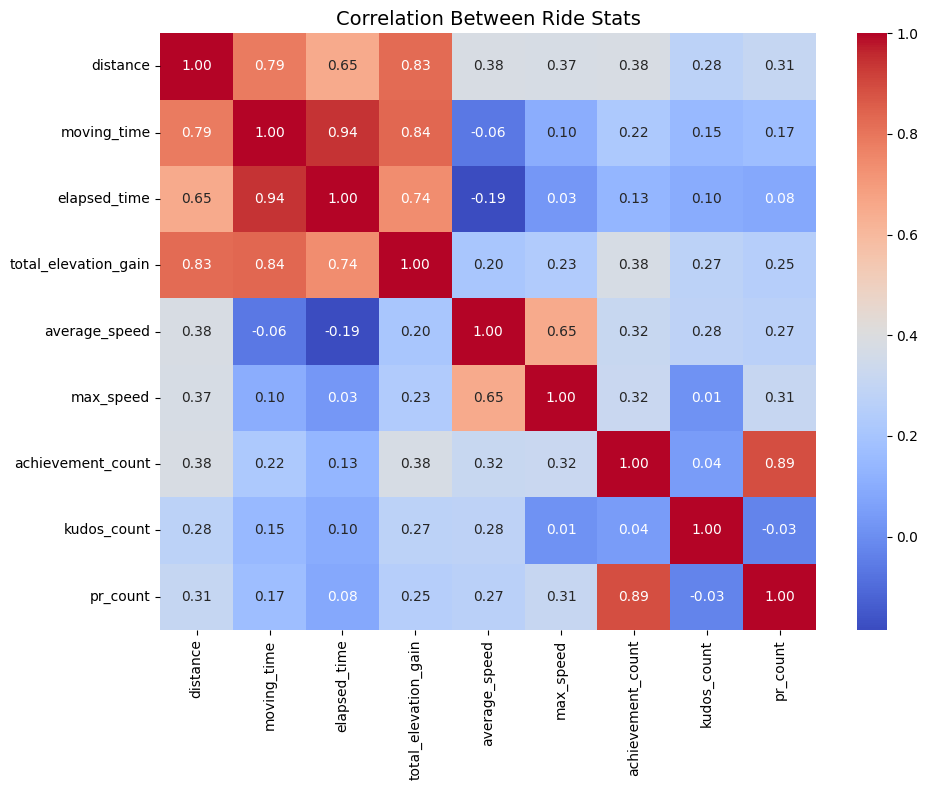

In [17]:
features = df[[
    "distance", "moving_time", "elapsed_time", 
    "total_elevation_gain", "average_speed", "max_speed", 
    "achievement_count", "kudos_count", "pr_count"
]]

plt.figure(figsize=(10, 8))
sns.heatmap(features.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Ride Stats", fontsize=14)
plt.tight_layout()
plt.savefig(plots_dir / "correlation_heatmap.png")
plt.show()

## 9. Time Series Data Trends

### 9.1 Setup

In [18]:
df['start_date'] = pd.to_datetime(df['start_date']).dt.tz_localize(None)  # Remove timezone

# === MONTHLY STATS ===
df['month'] = df['start_date'].dt.to_period('M').dt.to_timestamp()
monthly_stats = df.groupby('month')[['distance', 'moving_time', 'total_elevation_gain']].sum()

# Convert average speed to km/h
df['speed_kmh'] = df['average_speed'] * 3.6

# Get list of all activity types
activity_types = df['type'].dropna().unique()

# Ensure full range from Jan 2023
full_month_range = pd.date_range(start='2024-01-01', end=df['start_date'].max(), freq='MS')
full_month_index = pd.MultiIndex.from_product([full_month_range, activity_types], names=['month', 'type'])
monthly_stats = monthly_stats.reindex(full_month_range, fill_value=0)
monthly_stats.index.name = 'month'
monthly_stats = monthly_stats.reset_index()

# Convert monthly units
#monthly_stats['distance_km'] = monthly_stats['distance'] / 1609.34
#monthly_stats['elev_gain_ft'] = monthly_stats['total_elevation_gain'] * 3.28084
monthly_stats['distance_km'] = monthly_stats['distance'] / 1000
monthly_stats['elev_gain_m'] = monthly_stats['total_elevation_gain']
monthly_stats['moving_hours'] = monthly_stats['moving_time'] / 3600
monthly_speed = df.groupby(['month', 'type'])['speed_kmh'].mean().reindex(full_month_index).reset_index()

# === WEEKLY STATS ===
df['week'] = df['start_date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_stats = df.groupby('week')[['distance', 'moving_time', 'total_elevation_gain']].sum()

# Ensure full range from Jan 2023
full_week_range = pd.date_range(start='2024-01-01', end=df['start_date'].max(), freq='W-MON')
full_week_index = pd.MultiIndex.from_product([full_week_range, activity_types], names=['week', 'type'])
weekly_stats = weekly_stats.reindex(full_week_range, fill_value=0)
weekly_stats.index.name = 'week'
weekly_stats = weekly_stats.reset_index()

# Convert weekly units
#weekly_stats['distance_mi'] = weekly_stats['distance'] / 1609.34
#weekly_stats['elev_gain_ft'] = weekly_stats['total_elevation_gain'] * 3.28084
weekly_stats['distance_km'] = weekly_stats['distance'] / 1000
weekly_stats['elev_gain_m'] = weekly_stats['total_elevation_gain']
weekly_stats['moving_hours'] = weekly_stats['moving_time'] / 3600
weekly_speed = df.groupby(['week', 'type'])['speed_kmh'].mean().reindex(full_week_index).reset_index()

### 9.2 Monthly Distance Plot

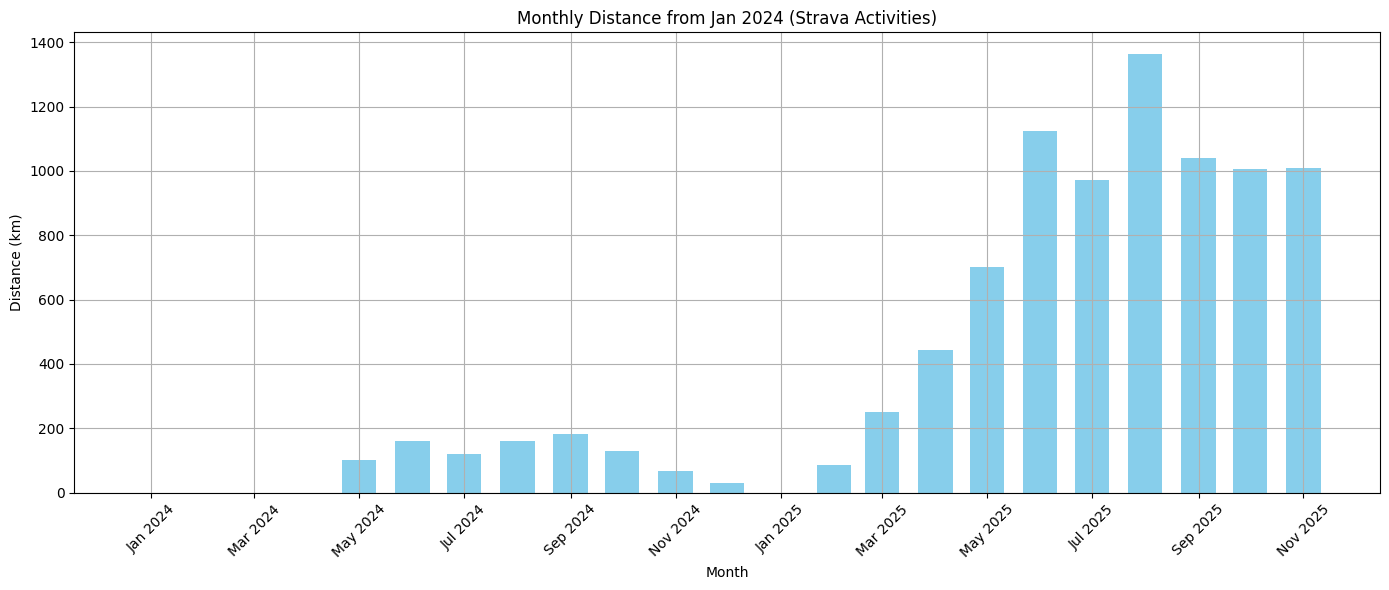

In [19]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(monthly_stats['month'], monthly_stats['distance_km'], width=20, color='skyblue')
ax.set_title("Monthly Distance from Jan 2024 (Strava Activities)")
ax.set_xlabel("Month")
ax.set_ylabel("Distance (km)")
ax.set_xticks(monthly_stats['month'][::2])
ax.set_xticklabels(monthly_stats['month'][::2].dt.strftime('%b %Y'), rotation=45)
ax.grid(True)
plt.tight_layout()
plt.savefig(plots_dir / "monthly_distance.png")
plt.show()

### 9.3 Weekly Distance Plot

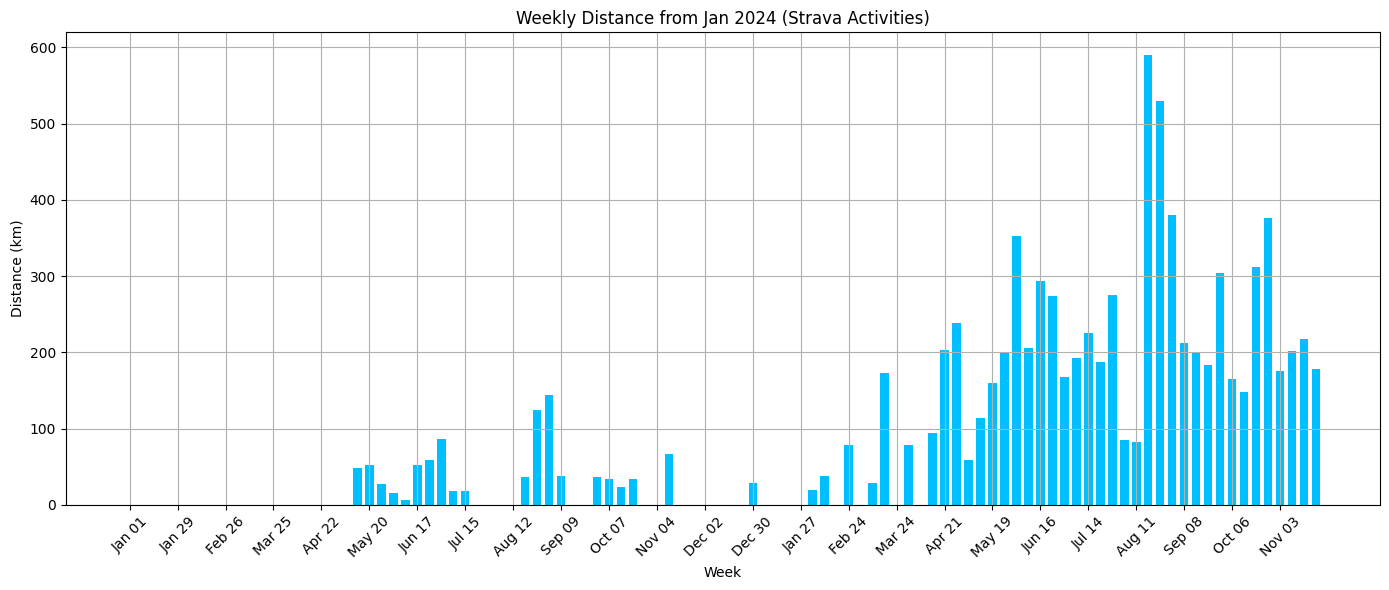

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(weekly_stats['week'], weekly_stats['distance_km'], width=5, color='deepskyblue')
ax.set_title("Weekly Distance from Jan 2024 (Strava Activities)")
ax.set_xlabel("Week")
ax.set_ylabel("Distance (km)")
ax.set_xticks(weekly_stats['week'][::4])
ax.set_xticklabels(weekly_stats['week'][::4].dt.strftime('%b %d'), rotation=45)
ax.grid(True)
plt.tight_layout()
plt.savefig(plots_dir / "weekly_distance.png")
plt.show()

### 9.4 Monthly Elevation Gain Plot

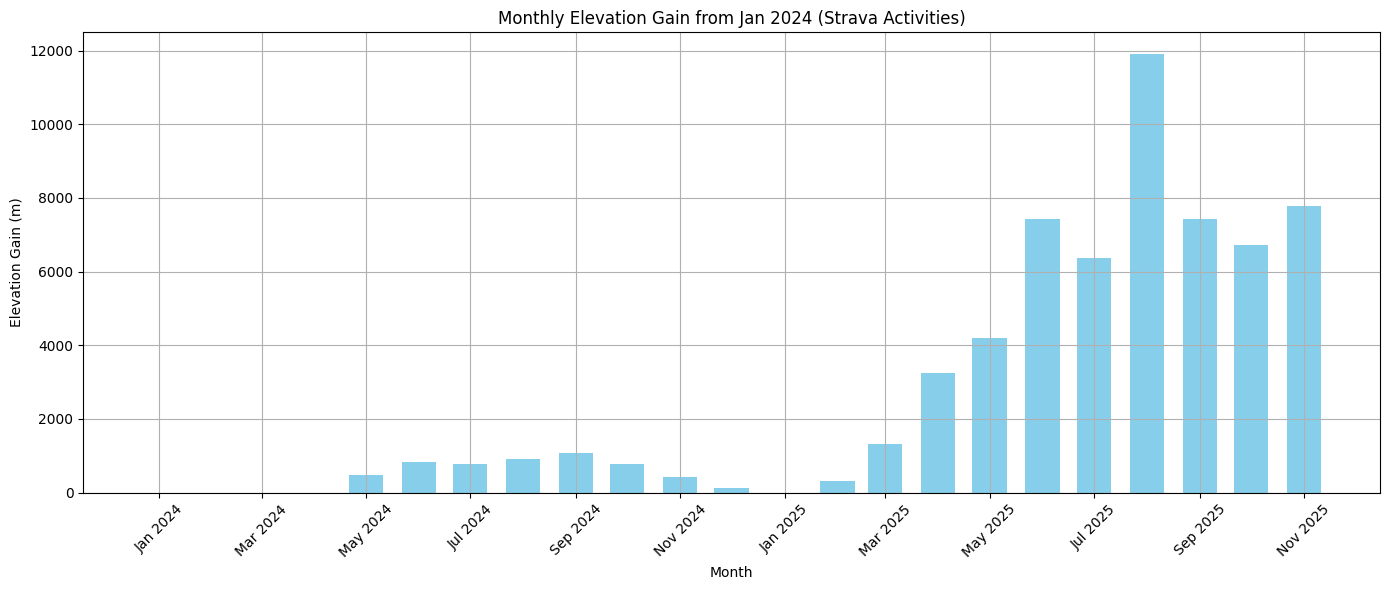

In [21]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(monthly_stats['month'], monthly_stats['elev_gain_m'], width=20, color='skyblue')
ax.set_title("Monthly Elevation Gain from Jan 2024 (Strava Activities)")
ax.set_xlabel("Month")
ax.set_ylabel("Elevation Gain (m)")
ax.set_xticks(monthly_stats['month'][::2])
ax.set_xticklabels(monthly_stats['month'][::2].dt.strftime('%b %Y'), rotation=45)
ax.grid(True)
plt.tight_layout()
plt.savefig(plots_dir / "monthly_elevation_gain.png")
plt.show()

### 9.5 Weekly Elevation Gain Plot

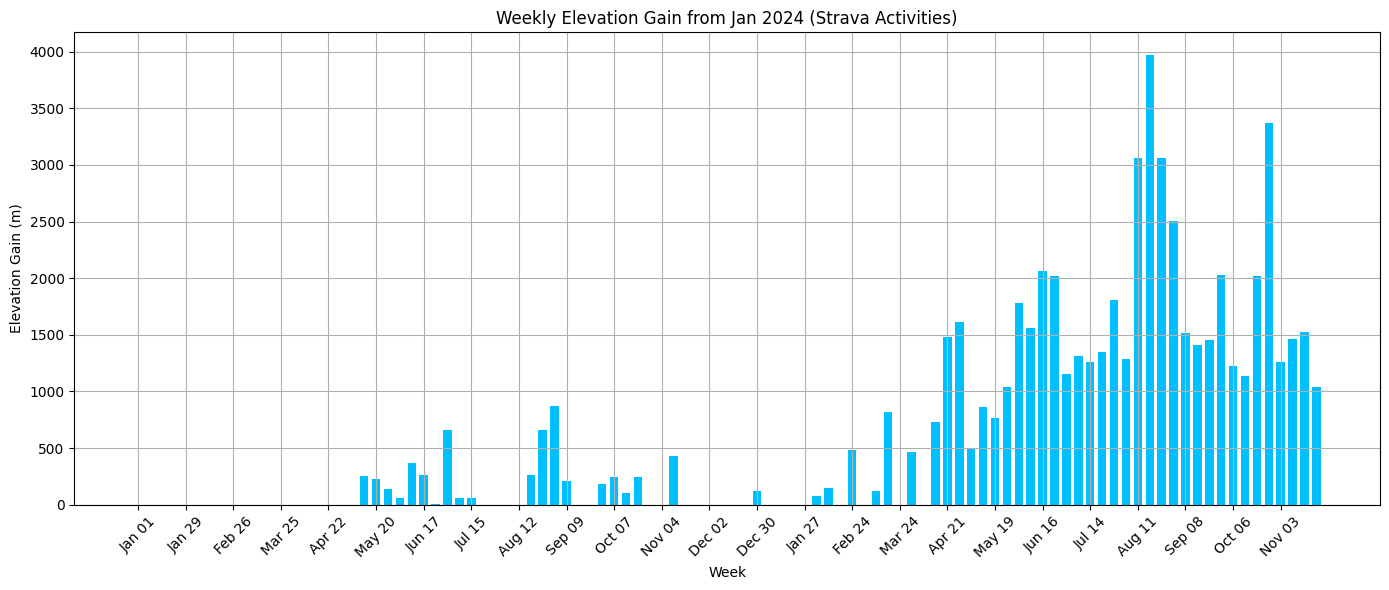

In [22]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(weekly_stats['week'], weekly_stats['elev_gain_m'], width=5, color='deepskyblue')
ax.set_title("Weekly Elevation Gain from Jan 2024 (Strava Activities)")
ax.set_xlabel("Week")
ax.set_ylabel("Elevation Gain (m)")
ax.set_xticks(weekly_stats['week'][::4])
ax.set_xticklabels(weekly_stats['week'][::4].dt.strftime('%b %d'), rotation=45)
ax.grid(True)
plt.tight_layout()
plt.savefig(plots_dir / "weekly_elevation_gain.png")
plt.show()

### 9.6 Monthly Moving Hours Plot

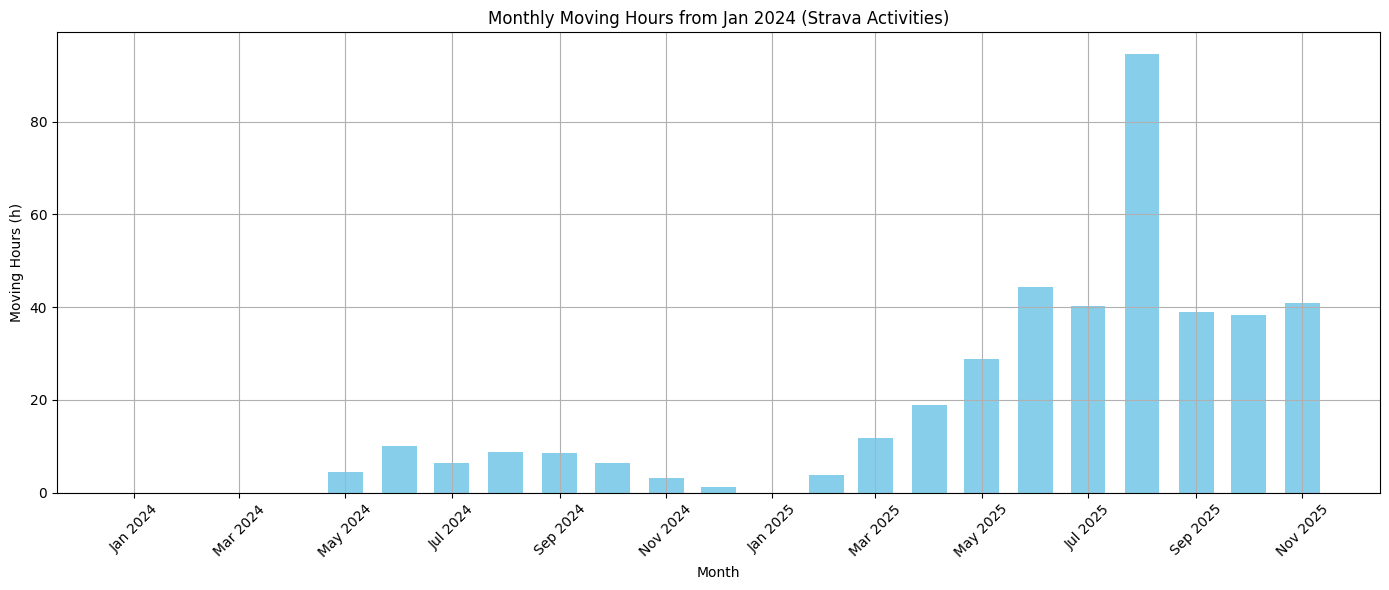

In [23]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(monthly_stats['month'], monthly_stats['moving_hours'], width=20, color='skyblue')
ax.set_title("Monthly Moving Hours from Jan 2024 (Strava Activities)")
ax.set_xlabel("Month")
ax.set_ylabel("Moving Hours (h)")
ax.set_xticks(monthly_stats['month'][::2])
ax.set_xticklabels(monthly_stats['month'][::2].dt.strftime('%b %Y'), rotation=45)
ax.grid(True)
plt.tight_layout()
plt.savefig(plots_dir / "monthly_moving_hours.png")
plt.show()

### 9.7 Weekly Moving Hours Plot

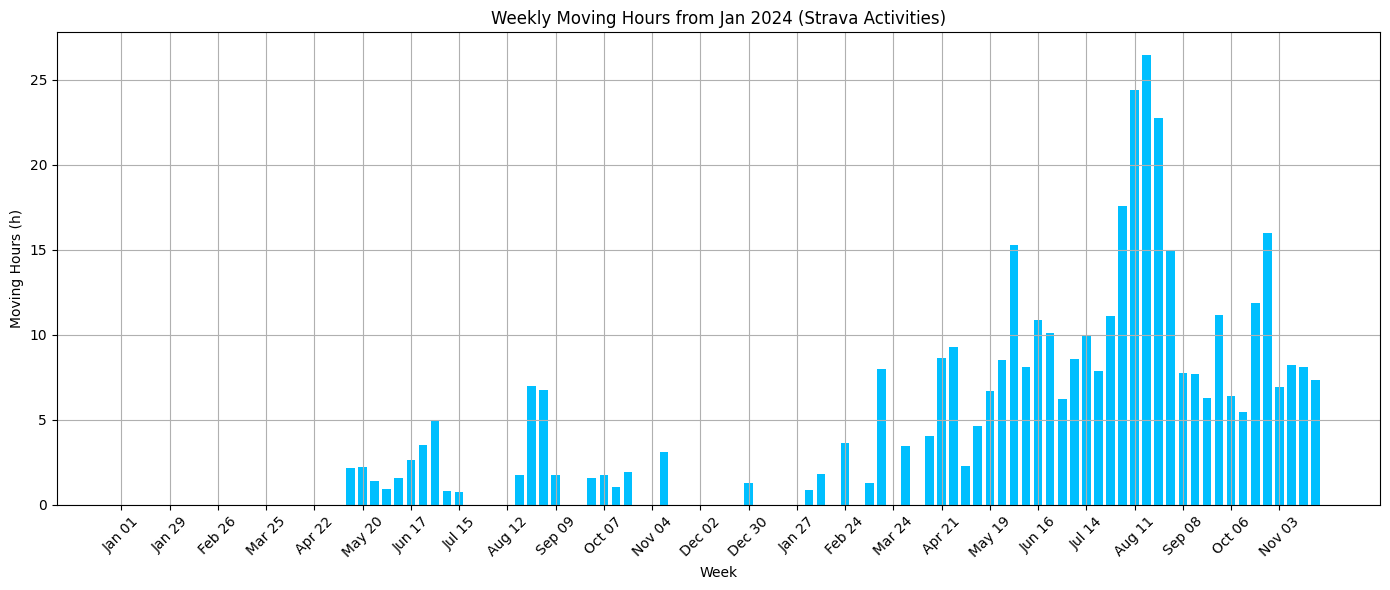

In [24]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(weekly_stats['week'], weekly_stats['moving_hours'], width=5, color='deepskyblue')
ax.set_title("Weekly Moving Hours from Jan 2024 (Strava Activities)")
ax.set_xlabel("Week")
ax.set_ylabel("Moving Hours (h)")
ax.set_xticks(weekly_stats['week'][::4])
ax.set_xticklabels(weekly_stats['week'][::4].dt.strftime('%b %d'), rotation=45)
ax.grid(True)
plt.tight_layout()
plt.savefig(plots_dir / "weekly_moving_hours.png")
plt.show()

### 9.8 Monthly Average Speed

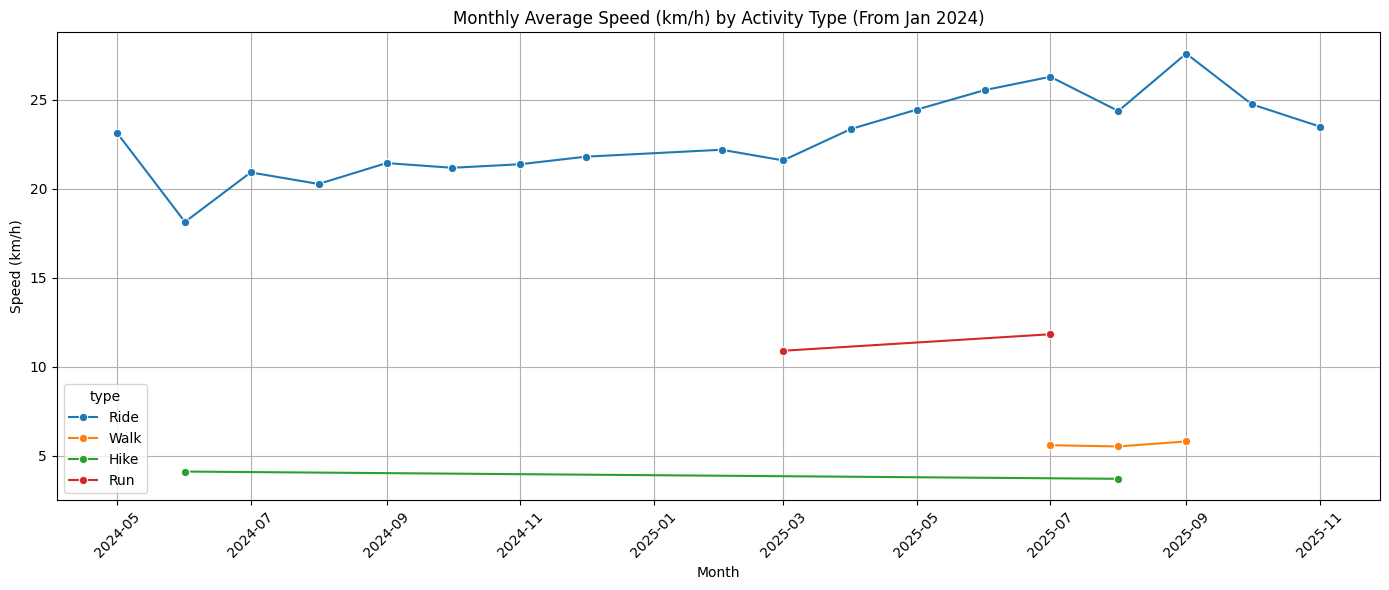

In [25]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_speed, x='month', y='speed_kmh', hue='type', marker='o')
plt.title("Monthly Average Speed (km/h) by Activity Type (From Jan 2024)")
plt.xlabel("Month")
plt.ylabel("Speed (km/h)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(plots_dir / "monthly_average_speed.png")
plt.show()

### 9.9 Weekly Average Speed

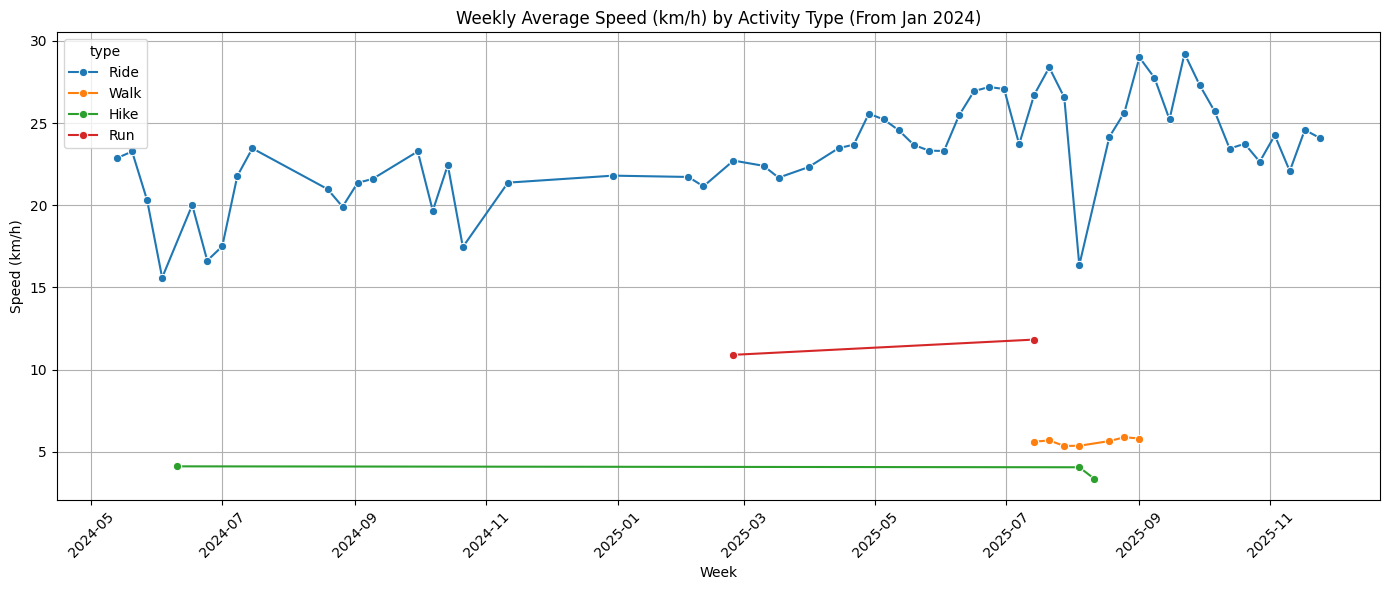

In [26]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly_speed, x='week', y='speed_kmh', hue='type', marker='o')
plt.title("Weekly Average Speed (km/h) by Activity Type (From Jan 2024)")
plt.xlabel("Week")
plt.ylabel("Speed (km/h)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(plots_dir / "weekly_average_speed.png")
plt.show()

## 10. Heatmap of Hours and Days of Activity

### 10.1 Setup

In [27]:
df['start_date'] = pd.to_datetime(df['start_date'])

# Step 1: Localize to UTC if timestamps are naive
if df['start_date'].dt.tz is None:
    df['start_date'] = df['start_date'].dt.tz_localize('UTC')

# Step 2: Convert to US Eastern Time (EST/EDT)
df['start_date_est'] = df['start_date'].dt.tz_convert('America/New_York')

### 10.2 Heatmap

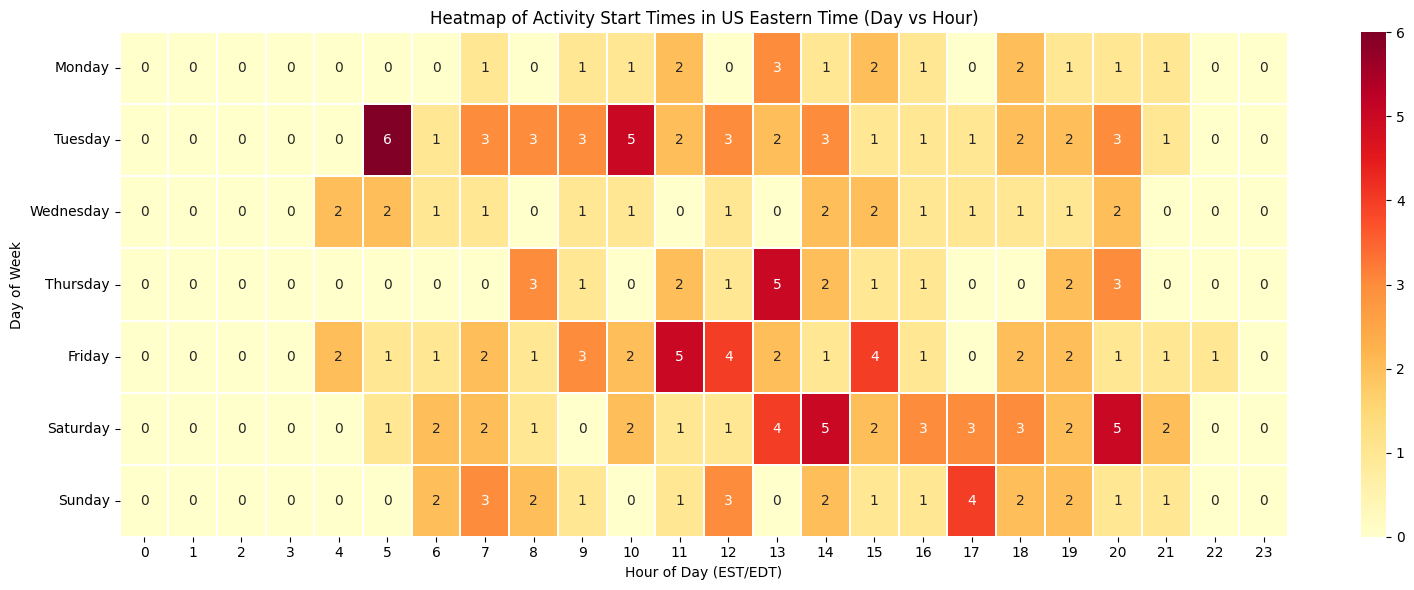

In [28]:
# Extract weekday and hour in local time
df['weekday'] = df['start_date_est'].dt.day_name()
df['hour'] = df['start_date_est'].dt.hour

# Group by weekday and hour
heatmap_data = df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)

# Reindex to ensure all 24 hours and all days are present
all_hours = list(range(24))
all_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(index=all_days, columns=all_hours, fill_value=0)

# Plot the heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.3, linecolor='white', annot=True, fmt='d')
plt.title("Heatmap of Activity Start Times in US Eastern Time (Day vs Hour)")
plt.xlabel("Hour of Day (EST/EDT)")
plt.ylabel("Day of Week")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(plots_dir / "activity_start_times_heatmap.png")
plt.show()

### 10.3 Printing Activity Type

In [29]:
# Select and sort
activity_times = df[['start_date_est', 'type']].sort_values('start_date_est')

# Print nicely
for idx, row in activity_times.iterrows():
    print(f"{row['start_date_est'].strftime('%Y-%m-%d %I:%M %p %Z')} — {row['type']}")

2024-05-14 02:29 PM EDT — Ride
2024-05-20 06:29 PM EDT — Ride
2024-05-23 02:20 PM EDT — Ride
2024-06-01 11:38 AM EDT — Ride
2024-06-04 11:27 AM EDT — Ride
2024-06-15 06:22 AM EDT — Hike
2024-06-20 01:21 PM EDT — Ride
2024-06-29 10:07 AM EDT — Ride
2024-07-05 09:10 AM EDT — Ride
2024-07-13 05:27 PM EDT — Ride
2024-07-21 07:16 PM EDT — Ride
2024-08-25 05:08 PM EDT — Ride
2024-08-26 06:14 PM EDT — Ride
2024-08-27 06:01 AM EDT — Ride
2024-09-02 03:21 PM EDT — Ride
2024-09-06 10:25 AM EDT — Ride
2024-09-13 03:02 PM EDT — Ride
2024-10-01 05:29 PM EDT — Ride
2024-10-05 04:12 PM EDT — Ride
2024-10-12 01:51 PM EDT — Ride
2024-10-12 06:27 PM EDT — Ride
2024-10-18 04:55 PM EDT — Ride
2024-10-19 07:46 PM EDT — Ride
2024-10-26 02:21 PM EDT — Ride
2024-11-16 02:16 PM EST — Ride
2024-12-30 02:05 PM EST — Ride
2025-02-07 11:15 AM EST — Ride
2025-02-11 09:37 AM EST — Ride
2025-02-14 09:27 AM EST — Ride
2025-02-26 03:04 PM EST — Ride
2025-03-01 03:57 PM EST — Ride
2025-03-02 12:07 PM EST — Run
2025-03-1

## 11. Activity per Weekday

### 11.1 Setup

In [30]:
# Convert the start_date column to datetime
df['start_date'] = pd.to_datetime(df['start_date'])

# Extract the weekday name from the start_date
df['weekday'] = df['start_date'].dt.day_name()

# Define the correct order of weekdays
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Count the number of activities per weekday and reorder them
activity_counts = df['weekday'].value_counts().reindex(weekday_order)

### 11.2 Plot

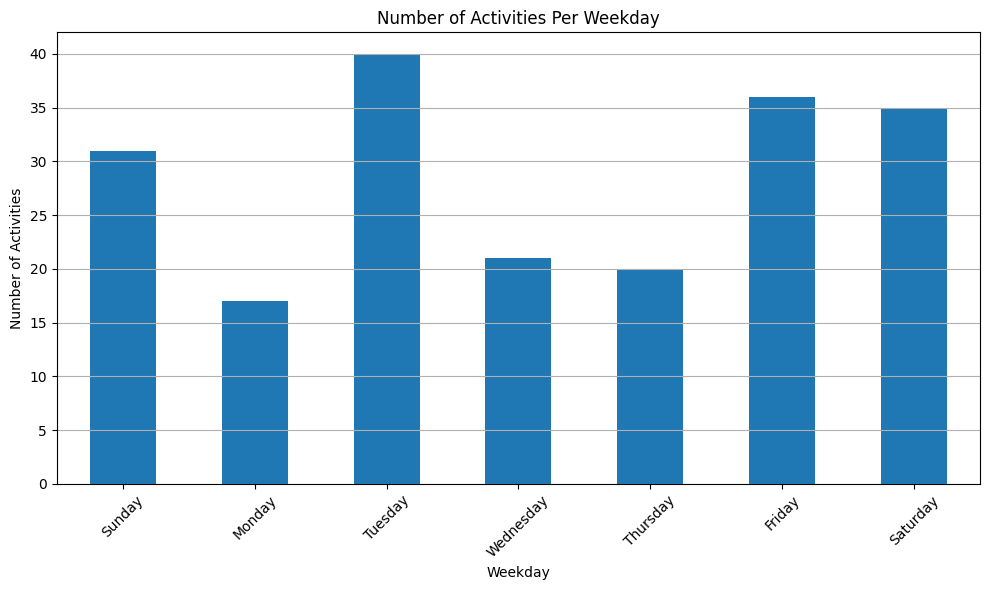

In [31]:
plt.figure(figsize=(10, 6))
activity_counts.plot(kind='bar')
plt.title("Number of Activities Per Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Activities")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(plots_dir / "activities_per_weekday.png")
plt.show()

## 12. Longest Active and Rest Period Streaks

In [32]:
# Ensure date_only is a datetime64[ns] type, not Python date
df['date_only'] = pd.to_datetime(df['start_date'].dt.date)

# Drop duplicates and sort the dates
unique_days = df['date_only'].drop_duplicates().sort_values().reset_index(drop=True)

# Create a shifted range to detect streaks
date_diffs = unique_days - pd.to_timedelta(range(len(unique_days)), unit='D')

# Group by the adjusted difference (same diff = part of same streak)
streak_groups = date_diffs.groupby(date_diffs).size()

# Longest streak is the max streak group size
longest_streak = streak_groups.max()

# Longest rest period = max difference between activity days - 1
longest_rest = unique_days.diff().dt.days.fillna(0).max() - 1

print(f"Longest active streak: {longest_streak} days")
print(f"Longest rest period: {int(longest_rest)} days")

Longest active streak: 8 days
Longest rest period: 43 days


## 13. Activity Distribution Pi Chart

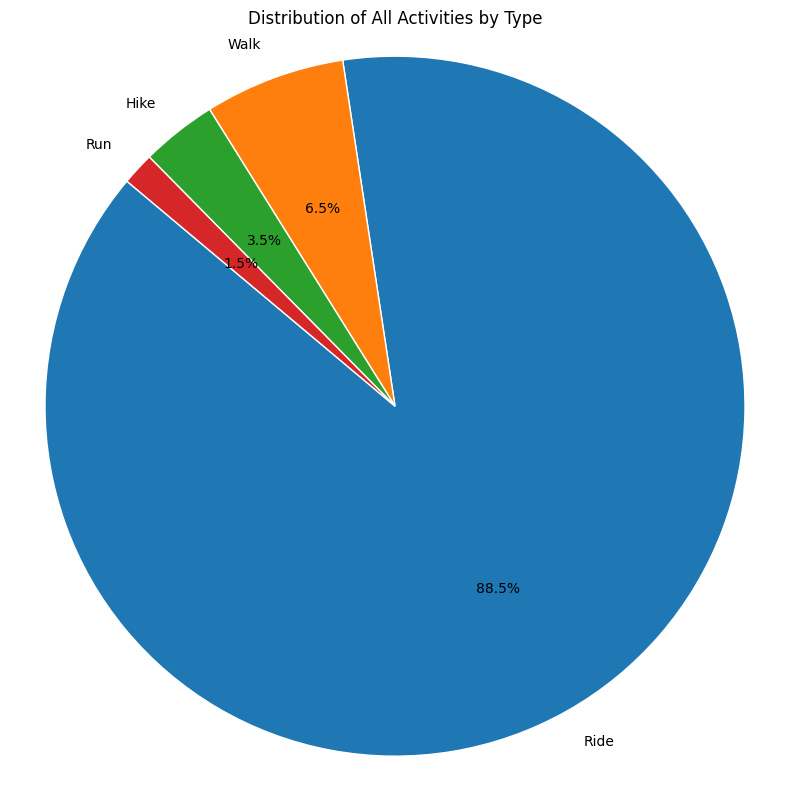

In [33]:
df['type'] = df['type'].fillna('Unknown')

# Count the number of each activity type
activity_counts = df['type'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(edgecolor='w'))
plt.title("Distribution of All Activities by Type")
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.tight_layout()
plt.savefig(plots_dir / "all_activities_pi_chart_distribution.png")
plt.show()

## 14. Power Measurements

### 14.1 Setup

In [34]:
# Parse datetime
df['start_date_local'] = pd.to_datetime(df['start_date_local'])

# Filter only rides from 2024 onwards
df = df[df['start_date_local'] >= "2024-01-01"]

# === Define constants ===
rider_mass = 54.43  # kg
bike_mass = 8.16    # kg
total_mass = rider_mass + bike_mass
g = 9.81
C_r = 0.005
rho = 1.225
C_d = 0.88
A = 0.5
ftp = 250

# === Estimate speed and gradient ===
df['speed_mps'] = df['distance'] / df['moving_time']
df['gradient'] = (df['total_elevation_gain'] / df['distance']) * 100
df['gradient_rad'] = np.arctan(df['gradient'] / 100.0)

# === Physics-based power estimate ===
power_gravity = total_mass * g * df['speed_mps'] * np.sin(df['gradient_rad'])
power_rolling = C_r * total_mass * g * df['speed_mps']
power_aero = 0.5 * rho * C_d * A * (df['speed_mps'] ** 3)
physics_power = power_gravity + power_rolling + power_aero

# === Use average_watts if available, fallback to physics estimate ===
df['estimated_power'] = df['average_watts']
missing_mask = df['estimated_power'].isna()
df.loc[missing_mask, 'estimated_power'] = physics_power[missing_mask]

# === Classify each ride into a primary zone based on average power
def classify_zone(power):
    pct = power / ftp
    if pct < 0.55:
        return "Z1 - Recovery"
    elif pct < 0.75:
        return "Z2 - Endurance"
    elif pct < 0.90:
        return "Z3 - Tempo"
    elif pct < 1.05:
        return "Z4 - Threshold"
    elif pct < 1.20:
        return "Z5 - VO2 Max"
    elif pct < 1.50:
        return "Z6 - Anaerobic"
    else:
        return "Z7 - Neuromuscular"

df['power_zone'] = df['estimated_power'].apply(classify_zone)

# === Show all zones encountered per ride ===
# Since we're working with per-ride summary data, each ride has only one zone.
# So instead, count how many times each zone has been assigned.
zone_counts_per_ride = df.groupby('power_zone').size().sort_index()

### 14.2 Summary Table

In [35]:
zone_summary = df[['start_date_local', 'name', 'estimated_power', 'power_zone']].copy()
zone_summary = zone_summary.sort_values('start_date_local')
zone_summary['estimated_power'] = zone_summary['estimated_power'].round(1)
zone_summary.rename(columns={
    'start_date_local': 'Date',
    'name': 'Ride Name',
    'estimated_power': 'Est. Power (W)',
    'power_zone': 'Power Zone'
}, inplace=True)

print("Power Zones Per Ride (All Time):")
display(zone_summary.reset_index(drop=True))

zone_summary.to_csv("power_zone_summary.csv", index=False)

Power Zones Per Ride (All Time):


,Date,Ride Name,Est. Power (W),Power Zone
0,2024-05-14 14:29:08+00:00,Ride 1,108.9,Z1 - Recovery
1,2024-05-20 18:29:12+00:00,Ride 2,97.6,Z1 - Recovery
2,2024-05-23 14:20:20+00:00,Ride 3,121.0,Z1 - Recovery
3,2024-06-01 17:38:57+00:00,Ride 4,83.5,Z1 - Recovery
4,2024-06-04 17:27:28+00:00,Ride 5,45.4,Z1 - Recovery
...,...,...,...,...
195,2025-11-25 05:19:41+00:00,Ride 121,110.0,Z1 - Recovery
196,2025-11-26 12:08:40+00:00,Lunch Ride,109.5,Z1 - Recovery
197,2025-11-26 16:20:31+00:00,Afternoon Ride,99.2,Z1 - Recovery
198,2025-11-27 15:37:45+00:00,Afternoon Ride,108.7,Z1 - Recovery


### 14.3 Average Estimated Power

In [36]:
avg_power_all_time = df['estimated_power'].mean()
avg_power_2024 = df[df['start_date_local'].dt.year == 2024]['estimated_power'].mean()
avg_power_2025 = df[df['start_date_local'].dt.year == 2025]['estimated_power'].mean()

print(f"\nAverage Estimated Power (All Time): {avg_power_all_time:.2f} W")
print(f"Average Estimated Power (2024): {avg_power_2024:.2f} W")
print(f"Average Estimated Power (2025): {avg_power_2025:.2f} W")


Average Estimated Power (All Time): 108.41 W
Average Estimated Power (2024): 88.37 W
Average Estimated Power (2025): 111.40 W


### 14.4 Power Output per Ride

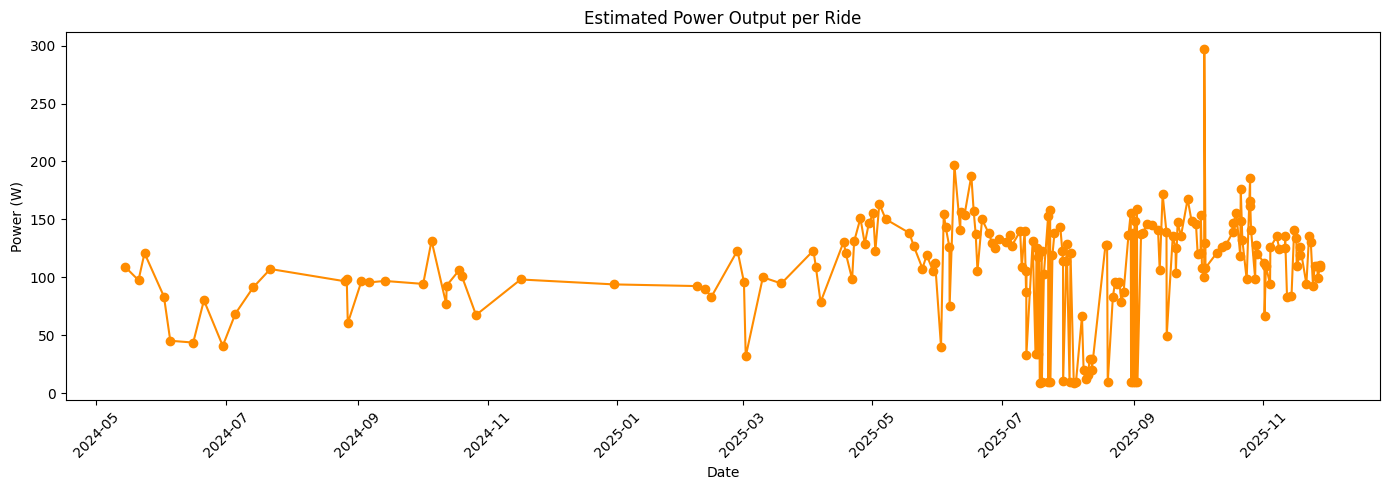

In [37]:
plt.figure(figsize=(14, 5))
plt.plot(df['start_date_local'], df['estimated_power'], marker='o', linestyle='-', color='darkorange')
plt.xticks(rotation=45)
plt.title("Estimated Power Output per Ride")
plt.xlabel("Date")
plt.ylabel("Power (W)")
plt.tight_layout()
plt.savefig(plots_dir / "power_output_per_ride.png")
plt.show()

### 14.5 Power Zones Encountered

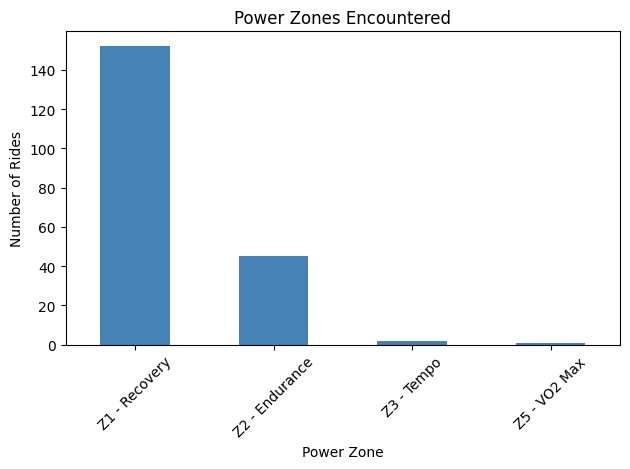

In [38]:
zone_counts_per_ride.plot(kind='bar', color='steelblue', title="Power Zones Encountered")
plt.xlabel("Power Zone")
plt.ylabel("Number of Rides")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plots_dir / "power_zone_frequency.png")
plt.show()

### 14.6 Power Zone per Ride

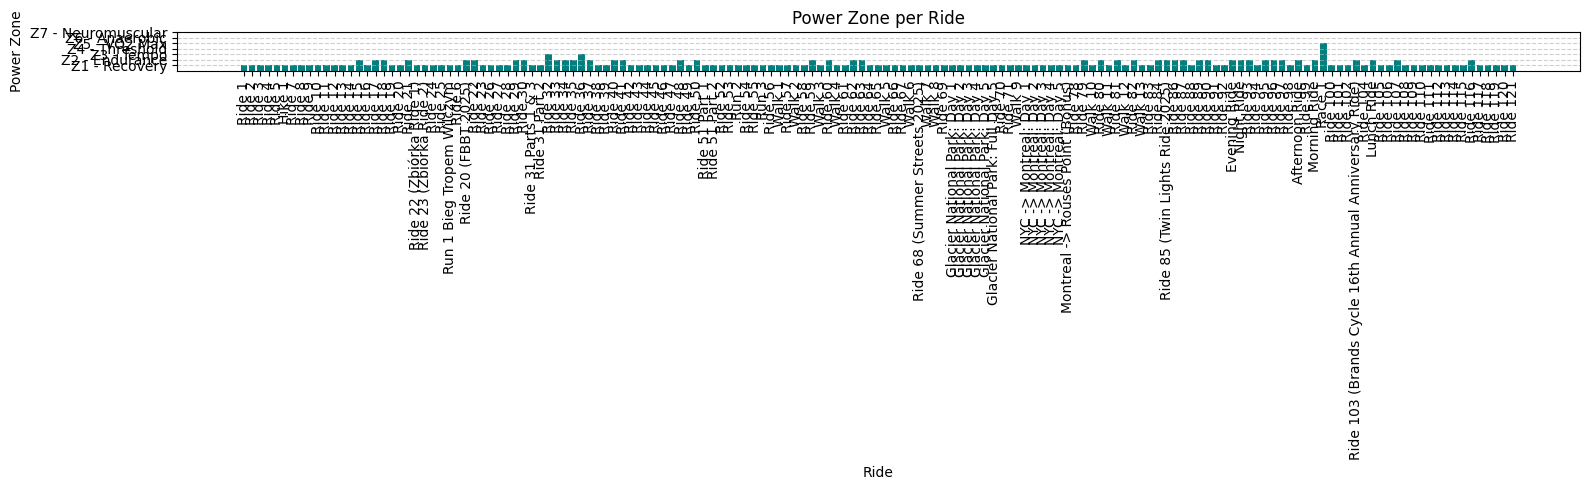

In [39]:
# Map zones to integers for plotting
zone_order = [
    "Z1 - Recovery", "Z2 - Endurance", "Z3 - Tempo", "Z4 - Threshold",
    "Z5 - VO2 Max", "Z6 - Anaerobic", "Z7 - Neuromuscular"
]
zone_mapping = {zone: i + 1 for i, zone in enumerate(zone_order)}
zone_summary['zone_numeric'] = zone_summary['Power Zone'].map(zone_mapping)

# Plot
plt.figure(figsize=(16, 5))
plt.bar(
    x=zone_summary['Ride Name'],
    height=zone_summary['zone_numeric'],
    color='teal'
)

# Label formatting
plt.title("Power Zone per Ride")
plt.xlabel("Ride")
plt.ylabel("Power Zone")
plt.xticks(rotation=90)
plt.yticks(ticks=list(zone_mapping.values()), labels=zone_order)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 15. Total Time Working Out in a Year

### 15.1 Setup

In [40]:
# Column storing activity type in Strava export
activity_col = "type"   

# Which activity types count as "working out"
active_sports = [
    "Ride", "Run", "Walk", "Hike", 
]

df_base = df[df[activity_col].isin(active_sports)].copy()
df_base["start_dt"] = pd.to_datetime(df_base["start_date_local"])
df_base["year"] = df_base["start_dt"].dt.year

if np.issubdtype(df_base["moving_time"].dtype, np.number):
    df_base["moving_td"] = pd.to_timedelta(df_base["moving_time"], unit="s")
else:
    df_base["moving_td"] = pd.to_timedelta(df_base["moving_time"])

df_base["date"] = df_base["start_dt"].dt.date
df_base["week"] = df_base["start_dt"].dt.to_period("W").apply(lambda r: r.start_time.date())
df_base["month"] = df_base["start_dt"].dt.to_period("M").astype(str)

def fmt_td(td):
    total_seconds = int(td.total_seconds())
    h, rem = divmod(total_seconds, 3600)
    m, s = divmod(rem, 60)
    return f"{h:02d}h {m:02d}m {s:02d}s"

def td_breakdown(td):
    """Return (HH:MM:SS, days, weeks, months)."""
    total_seconds = int(td.total_seconds())
    days = total_seconds / 86400
    weeks = days / 7
    months = days / 30.4375  
    return fmt_td(td), days, weeks, months

def run_summaries(df_active, label):
    print("\n" + "#" * 70)
    print(f"SUMMARY FOR {label}")
    print("#" * 70)

    grand_total = df_active["moving_td"].sum()
    hhmmss, days, weeks, months = td_breakdown(grand_total)

    print(f"\n=== GRAND TOTAL ACTIVE TIME ({label}) ===")
    print(f"HH:MM:SS → {hhmmss}")
    print(f"Days     → {days:.2f}")
    print(f"Weeks    → {weeks:.2f}")
    print(f"Months   → {months:.2f} (approx.)")

    type_totals = (
        df_active.groupby(activity_col)["moving_td"]
        .sum()
        .sort_values(ascending=False)
    )

    print(f"\n=== Total moving time by activity type ({label}) ===")
    for activity, td in type_totals.items():
        ahhmmss, adays, aweeks, amonths = td_breakdown(td)
        print(f"\n{activity}:")
        print(f"  HH:MM:SS → {ahhmmss}")
        print(f"  Days     → {adays:.2f}")
        print(f"  Weeks    → {aweeks:.2f}")
        print(f"  Months   → {amonths:.2f} (approx.)")

    month_activity_totals = (
        df_active.groupby(["month", activity_col])["moving_td"]
        .sum()
        .sort_index()
    )

    print(f"\n=== Total active time per month ({label}, by activity) ===")
    for month, group in month_activity_totals.groupby(level=0):
        month_td = group.sum()
        mhhmmss, mdays, mweeks, mmonths = td_breakdown(month_td)

        print(f"\n{month}:")
        print(f"  TOTAL → {mhhmmss} | {mdays:.2f} days | {mweeks:.2f} weeks | {mmonths:.2f} months")
        for activity, td in group.items():
            ahhmmss, adays, aweeks, amonths = td_breakdown(td)
            print(f"    {activity}: {ahhmmss} | {adays:.2f} d | {aweeks:.2f} w | {amonths:.2f} mo")

for label, years in [
    ("2024 only", [2024]),
    ("2025 only", [2025]),
    ("2024-2025 combined", [2024, 2025]),
]:
    mask = df_base["year"].isin(years)
    run_summaries(df_base[mask], label)


######################################################################
SUMMARY FOR 2024 only
######################################################################

=== GRAND TOTAL ACTIVE TIME (2024 only) ===
HH:MM:SS → 48h 48m 33s
Days     → 2.03
Weeks    → 0.29
Months   → 0.07 (approx.)

=== Total moving time by activity type (2024 only) ===

Ride:
  HH:MM:SS → 47h 13m 49s
  Days     → 1.97
  Weeks    → 0.28
  Months   → 0.06 (approx.)

Hike:
  HH:MM:SS → 01h 34m 44s
  Days     → 0.07
  Weeks    → 0.01
  Months   → 0.00 (approx.)

=== Total active time per month (2024 only, by activity) ===

2024-05:
  TOTAL → 04h 20m 47s | 0.18 days | 0.03 weeks | 0.01 months
    ('2024-05', 'Ride'): 04h 20m 47s | 0.18 d | 0.03 w | 0.01 mo

2024-06:
  TOTAL → 10h 04m 03s | 0.42 days | 0.06 weeks | 0.01 months
    ('2024-06', 'Hike'): 01h 34m 44s | 0.07 d | 0.01 w | 0.00 mo
    ('2024-06', 'Ride'): 08h 29m 19s | 0.35 d | 0.05 w | 0.01 mo

2024-07:
  TOTAL → 06h 28m 08s | 0.27 days | 0.04 weeks | 0.0

/var/folders/tn/32z4w571133dsqv90ql_s7gw0000gn/T/ipykernel_15435/2115755383.py:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_base["week"] = df_base["start_dt"].dt.to_period("W").apply(lambda r: r.start_time.date())
/var/folders/tn/32z4w571133dsqv90ql_s7gw0000gn/T/ipykernel_15435/2115755383.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_base["month"] = df_base["start_dt"].dt.to_period("M").astype(str)


### 15.2 Total moving time by activity type, with days/weeks/months

In [41]:
for label, years in [
    ("2024 only", [2024]),
    ("2025 only", [2025]),
    ("2024-2025 combined", [2024, 2025]),
]:
    df_sub = df_base[df_base["year"].isin(years)]

    type_totals = (
        df_sub.groupby(activity_col)["moving_td"]
        .sum()
        .sort_values(ascending=False)
    )

    print(f"\n=== Total moving time by activity type ({label}) ===")

    for activity, td in type_totals.items():
        hhmmss, total_days, total_weeks, total_months = td_breakdown(td)

        print(f"\n{activity}:")
        print(f"  HH:MM:SS → {hhmmss}")
        print(f"  Days     → {total_days:.2f}")
        print(f"  Weeks    → {total_weeks:.2f}")
        print(f"  Months   → {total_months:.2f} (approx.)")


=== Total moving time by activity type (2024 only) ===

Ride:
  HH:MM:SS → 47h 13m 49s
  Days     → 1.97
  Weeks    → 0.28
  Months   → 0.06 (approx.)

Hike:
  HH:MM:SS → 01h 34m 44s
  Days     → 0.07
  Weeks    → 0.01
  Months   → 0.00 (approx.)

=== Total moving time by activity type (2025 only) ===

Ride:
  HH:MM:SS → 310h 33m 57s
  Days     → 12.94
  Weeks    → 1.85
  Months   → 0.43 (approx.)

Hike:
  HH:MM:SS → 39h 18m 35s
  Days     → 1.64
  Weeks    → 0.23
  Months   → 0.05 (approx.)

Walk:
  HH:MM:SS → 10h 00m 00s
  Days     → 0.42
  Weeks    → 0.06
  Months   → 0.01 (approx.)

Run:
  HH:MM:SS → 00h 27m 44s
  Days     → 0.02
  Weeks    → 0.00
  Months   → 0.00 (approx.)

=== Total moving time by activity type (2024-2025 combined) ===

Ride:
  HH:MM:SS → 357h 47m 46s
  Days     → 14.91
  Weeks    → 2.13
  Months   → 0.49 (approx.)

Hike:
  HH:MM:SS → 40h 53m 19s
  Days     → 1.70
  Weeks    → 0.24
  Months   → 0.06 (approx.)

Walk:
  HH:MM:SS → 10h 00m 00s
  Days     → 0.42
  

### 15.3 Total active time per month, separated by activity

In [42]:
for label, years in [
    ("2024 only", [2024]),
    ("2025 only", [2025]),
    ("2024-2025 combined", [2024, 2025]),
]:
    df_sub = df_base[df_base["year"].isin(years)]

    month_activity_totals = (
        df_sub
        .groupby(["month", activity_col])["moving_td"]
        .sum()
        .sort_index()
    )

    print(f"\n=== Total active time per month ({label}, by activity) ===")
    for month, group in month_activity_totals.groupby(level=0):
        month_td = group.sum()
        hhmmss, days, weeks, months = td_breakdown(month_td)

        print(f"\n{month}:")
        print(f"  TOTAL → {hhmmss} | {days:.2f} days | {weeks:.2f} weeks | {months:.2f} months (approx.)")

        for activity, td in group.items():
            ahhmmss, adays, aweeks, amonths = td_breakdown(td)
            print(f"    {activity}: {ahhmmss} | {adays:.2f} d | {aweeks:.2f} w | {amonths:.2f} mo")


=== Total active time per month (2024 only, by activity) ===

2024-05:
  TOTAL → 04h 20m 47s | 0.18 days | 0.03 weeks | 0.01 months (approx.)
    ('2024-05', 'Ride'): 04h 20m 47s | 0.18 d | 0.03 w | 0.01 mo

2024-06:
  TOTAL → 10h 04m 03s | 0.42 days | 0.06 weeks | 0.01 months (approx.)
    ('2024-06', 'Hike'): 01h 34m 44s | 0.07 d | 0.01 w | 0.00 mo
    ('2024-06', 'Ride'): 08h 29m 19s | 0.35 d | 0.05 w | 0.01 mo

2024-07:
  TOTAL → 06h 28m 08s | 0.27 days | 0.04 weeks | 0.01 months (approx.)
    ('2024-07', 'Ride'): 06h 28m 08s | 0.27 d | 0.04 w | 0.01 mo

2024-08:
  TOTAL → 08h 45m 16s | 0.36 days | 0.05 weeks | 0.01 months (approx.)
    ('2024-08', 'Ride'): 08h 45m 16s | 0.36 d | 0.05 w | 0.01 mo

2024-09:
  TOTAL → 08h 29m 47s | 0.35 days | 0.05 weeks | 0.01 months (approx.)
    ('2024-09', 'Ride'): 08h 29m 47s | 0.35 d | 0.05 w | 0.01 mo

2024-10:
  TOTAL → 06h 17m 03s | 0.26 days | 0.04 weeks | 0.01 months (approx.)
    ('2024-10', 'Ride'): 06h 17m 03s | 0.26 d | 0.04 w | 0.01 

### 15.4 Total active time per week, separated by activity

In [43]:
for label, years in [
    ("2024 only", [2024]),
    ("2025 only", [2025]),
    ("2024-2025 combined", [2024, 2025]),
]:
    df_sub = df_base[df_base["year"].isin(years)]

    week_activity_totals = (
        df_sub
        .groupby(["week", activity_col])["moving_td"]
        .sum()
        .sort_index()
    )

    print(f"\n=== Total active time per week ({label}, week starting, by activity) ===")
    for week_start, group in week_activity_totals.groupby(level=0):
        week_td = group.sum()
        hhmmss, days, weeks, months = td_breakdown(week_td)

        print(f"\nWeek starting {week_start}:")
        print(f"  TOTAL → {hhmmss} | {days:.2f} days | {weeks:.2f} weeks | {months:.2f} months (approx.)")

        for activity, td in group.items():
            ahhmmss, adays, aweeks, amonths = td_breakdown(td)
            print(f"    {activity}: {ahhmmss} | {adays:.2f} d | {aweeks:.2f} w | {amonths:.2f} mo")



=== Total active time per week (2024 only, week starting, by activity) ===

Week starting 2024-05-13:
  TOTAL → 02h 08m 09s | 0.09 days | 0.01 weeks | 0.00 months (approx.)
    (datetime.date(2024, 5, 13), 'Ride'): 02h 08m 09s | 0.09 d | 0.01 w | 0.00 mo

Week starting 2024-05-20:
  TOTAL → 02h 12m 38s | 0.09 days | 0.01 weeks | 0.00 months (approx.)
    (datetime.date(2024, 5, 20), 'Ride'): 02h 12m 38s | 0.09 d | 0.01 w | 0.00 mo

Week starting 2024-05-27:
  TOTAL → 01h 22m 15s | 0.06 days | 0.01 weeks | 0.00 months (approx.)
    (datetime.date(2024, 5, 27), 'Ride'): 01h 22m 15s | 0.06 d | 0.01 w | 0.00 mo

Week starting 2024-06-03:
  TOTAL → 00h 56m 52s | 0.04 days | 0.01 weeks | 0.00 months (approx.)
    (datetime.date(2024, 6, 3), 'Ride'): 00h 56m 52s | 0.04 d | 0.01 w | 0.00 mo

Week starting 2024-06-10:
  TOTAL → 01h 34m 44s | 0.07 days | 0.01 weeks | 0.00 months (approx.)
    (datetime.date(2024, 6, 10), 'Hike'): 01h 34m 44s | 0.07 d | 0.01 w | 0.00 mo

Week starting 2024-06-17

### 15.5 Total active time per day, separated by activity

In [44]:
for label, years in [
    ("2024 only", [2024]),
    ("2025 only", [2025]),
    ("2024-2025 combined", [2024, 2025]),
]:
    df_sub = df_base[df_base["year"].isin(years)]

    day_activity_totals = (
        df_sub
        .groupby(["date", activity_col])["moving_td"]
        .sum()
        .sort_index()
    )

    print(f"\n=== Total active time per day ({label}, by activity) ===")
    for date_val, group in day_activity_totals.groupby(level=0):
        day_td = group.sum()
        hhmmss, days, weeks, months = td_breakdown(day_td)

        print(f"\n{date_val}:")
        print(f"  TOTAL → {hhmmss} | {days:.2f} days | {weeks:.4f} weeks | {months:.4f} months (approx.)")

        for activity, td in group.items():
            ahhmmss, adays, aweeks, amonths = td_breakdown(td)
            print(f"    {activity}: {ahhmmss} | {adays:.2f} d | {aweeks:.4f} w | {amonths:.4f} mo")



=== Total active time per day (2024 only, by activity) ===

2024-05-14:
  TOTAL → 02h 08m 09s | 0.09 days | 0.0127 weeks | 0.0029 months (approx.)
    (datetime.date(2024, 5, 14), 'Ride'): 02h 08m 09s | 0.09 d | 0.0127 w | 0.0029 mo

2024-05-20:
  TOTAL → 00h 47m 20s | 0.03 days | 0.0047 weeks | 0.0011 months (approx.)
    (datetime.date(2024, 5, 20), 'Ride'): 00h 47m 20s | 0.03 d | 0.0047 w | 0.0011 mo

2024-05-23:
  TOTAL → 01h 25m 18s | 0.06 days | 0.0085 weeks | 0.0019 months (approx.)
    (datetime.date(2024, 5, 23), 'Ride'): 01h 25m 18s | 0.06 d | 0.0085 w | 0.0019 mo

2024-06-01:
  TOTAL → 01h 22m 15s | 0.06 days | 0.0082 weeks | 0.0019 months (approx.)
    (datetime.date(2024, 6, 1), 'Ride'): 01h 22m 15s | 0.06 d | 0.0082 w | 0.0019 mo

2024-06-04:
  TOTAL → 00h 56m 52s | 0.04 days | 0.0056 weeks | 0.0013 months (approx.)
    (datetime.date(2024, 6, 4), 'Ride'): 00h 56m 52s | 0.04 d | 0.0056 w | 0.0013 mo

2024-06-15:
  TOTAL → 01h 34m 44s | 0.07 days | 0.0094 weeks | 0.0022 m

### 15.6 Grand total for the year with days/weeks/months breakdown

In [45]:
for label, years in [
    ("2024 only", [2024]),
    ("2025 only", [2025]),
    ("2024-2025 combined", [2024, 2025]),
]:
    df_sub = df_base[df_base["year"].isin(years)]
    grand_total = df_sub["moving_td"].sum()

    hhmmss, total_days, total_weeks, total_months = td_breakdown(grand_total)

    print(f"\n=== GRAND TOTAL ACTIVE TIME ({label}) ===")
    print(f"HH:MM:SS → {hhmmss}")
    print(f"Days     → {total_days:.2f}")
    print(f"Weeks    → {total_weeks:.2f}")
    print(f"Months   → {total_months:.2f} (approx.)")



=== GRAND TOTAL ACTIVE TIME (2024 only) ===
HH:MM:SS → 48h 48m 33s
Days     → 2.03
Weeks    → 0.29
Months   → 0.07 (approx.)

=== GRAND TOTAL ACTIVE TIME (2025 only) ===
HH:MM:SS → 360h 20m 16s
Days     → 15.01
Weeks    → 2.14
Months   → 0.49 (approx.)

=== GRAND TOTAL ACTIVE TIME (2024-2025 combined) ===
HH:MM:SS → 409h 08m 49s
Days     → 17.05
Weeks    → 2.44
Months   → 0.56 (approx.)
